## Developing solutions to issue #10

* The first idea coming to my mind is to tight the criterion used to assign different expeditions (i.e. time_delta=30 secs in MatchingUsers.appendingIdExpedicion), and follow the same methodology as in MatchingUsers.py with the difference that a post-processing should be added in order to recognize _group B_ observations (again, look issue #10), adding a flag to them and eventually drop them in the notebook used to analyze data.
* As a first approach, _group B_ observations can be recognized going over the entire (sorted beforehand) dataset returned from MatchingUsers.groupByEtapasDatabase and checking for conditions.
* The conditions should look like 
if (sitio_subida(i-1) == sitio_subida(i) and
servicio_subida(i-1) == servicio_subida(i) and
par_subida(i-1) == par_subida (i) and 
__id_expedicion(i-1) + 1 == id_expedicion(i)__) then flag == 1.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from Utils import TransantiagoConstants
import EvasionBuilder

In [4]:
processed_evasion = EvasionBuilder.runCompleteProcess()

Original number of rows in complete evasion database is: 97373
Number of duplicated rows in complete evasion database is: 6192
Number of collapsed-duplicated rows in complete evasion database is: 3090
Number of rows in complete evasion database without duplicated rows at all is: 91181
Final number of rows in complete evasion database with collapsed duplicated rows is: 94271


C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The only non-matched user_code services are: 
D06


* Processing complete evasion-ddbb

In [5]:
evasion_paradero = processed_evasion[processed_evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

In [6]:
print('Number of rows in complete evasion database is: ' + str(len(processed_evasion.index)))
print('Number of rows in evasion in paradero database is: ' + str(len(evasion_paradero.index)))
print('Number of rows in evasion in paradero by first door database is: ' + str(len(evasion_paradero_first.index)))

Number of rows in complete evasion database is: 94271
Number of rows in evasion in paradero database is: 92604
Number of rows in evasion in paradero by first door database is: 33120


* Filtering dates not in common dates. DataFrame "common_dates_evasion" will be the final evasion DataFrame

In [7]:
common_dates = TransantiagoConstants.common_dates
common_dates_timestamp = [pd.to_datetime(x) for x in common_dates]
common_dates_evasion = evasion_paradero_first[evasion_paradero_first['FECHA'].isin(common_dates_timestamp)]

print('Number of rows in complete evasion database filtered by common_dates is: ' + str(len(common_dates_evasion.index))) #Remember to store the number.

Number of rows in complete evasion database filtered by common_dates is: 14632


* Building Etapas DataBase via <strong>RunSilentlyDailyEtapasBuilder</strong> and matching users via <strong>MatchingUsers</strong>

In [8]:
common_dates = ['2017-04-11'] #To debug and refactor

In [9]:
from RunSilentlyDailyEtapasBuilder import RunSilentlyDailyEtapasBuilderClass

In [10]:
import MatchingUsers

In [11]:
for date in common_dates:    
    etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
    processed_sorted_df = etapas_builder.runProcessedProcess()    
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace("-", "")
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace(" ", "")
    
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.replace('T','')
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.split(' ').str[0]
    
    print('The number of rows in the original etapas database is: ' + str(len(processed_sorted_df.index)) + ' rows.' )
    #Filtering special cases.
#    filtered_processed_sorted_df = processed_sorted_df[(processed_sorted_df['diferencia_tiempo_secs']<=20)|(processed_sorted_df['diferencia_tiempo_secs'].isnull())]
    filtered_processed_sorted_df = processed_sorted_df
    print('The number of rows in the filtered (by special cases) etapas database is: '  + str(len(filtered_processed_sorted_df.index)) + ' rows.' )
    
    [evasion_by_date, patentes_by_date, servicios_by_date] = MatchingUsers.simplifyingEvasion(common_dates_evasion,date) #Getting patentes and servicios surveyed in date...
    
    clean_sorted_df = filtered_processed_sorted_df[(filtered_processed_sorted_df['sitio_subida'].isin(patentes_by_date))&(filtered_processed_sorted_df['servicio_subida'].isin(servicios_by_date))] #Filtering...
    clean_sorted_df = clean_sorted_df.reset_index(drop=True)
    print('The number of rows in the clean_sorted_df is: '  + str(len(clean_sorted_df.index)) + ' rows.' )

    clean_sorted_df_1 = MatchingUsers.appendingIdExpedicion(clean_sorted_df,'30 seconds') #Appending (ad-hoc) id expedicion.
    grouped_clean_sorted_df_1 = MatchingUsers.groupByEtapasDatabase(clean_sorted_df_1) #Grouping by 'sitio_subida','servicio_subida','idExpedicion','par_subida'


Not found in turnstile database: 1829611
The number of rows in the original etapas database is: 2598131 rows.
The number of rows in the filtered (by special cases) etapas database is: 2598131 rows.
The number of rows in the clean_sorted_df is: 11937 rows.


* Here starts the developing

In [12]:
past_patente=''
past_servicio=''
past_paradero=''
past_expedicion = 0
grouped_clean_sorted_df_1['group_b_flag']=''

for index, row in grouped_clean_sorted_df_1.iterrows():
    actual_patente = row['sitio_subida']
    actual_servicio = row['servicio_subida']
    actual_paradero = row['par_subida']
    actual_expedicion = row['idExpedicion']
    if((past_patente==actual_patente)&(past_servicio==actual_servicio)&(past_paradero==actual_paradero)&(past_expedicion + 1 == actual_expedicion)):
        grouped_clean_sorted_df_1.loc[index,'group_b_flag'] = 1
    else:
        grouped_clean_sorted_df_1.loc[index,'group_b_flag'] = 0
        
    past_patente = actual_patente
    past_servicio = actual_servicio
    past_paradero = actual_paradero
    past_expedicion = actual_expedicion


* Developing indicators

In [13]:
len(grouped_clean_sorted_df_1.index)

4581

In [14]:
len(grouped_clean_sorted_df_1.loc[grouped_clean_sorted_df_1['group_b_flag']==1,:].index)

336

In [15]:
grouped_clean_sorted_df_1.loc[grouped_clean_sorted_df_1['group_b_flag']==1,'diferencia_tiempo_secs_mean'].describe()

count     336.000000
mean       69.451569
std       253.618126
min         7.047619
25%        25.458333
50%        40.000000
75%        62.250000
max      4592.000000
Name: diferencia_tiempo_secs_mean, dtype: float64

In [16]:
grouped_clean_sorted_df_1.loc[grouped_clean_sorted_df_1['group_b_flag']==0,'diferencia_tiempo_secs_mean'].describe()

count    2121.000000
mean        4.282859
std         4.041948
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        30.000000
Name: diferencia_tiempo_secs_mean, dtype: float64

* End developing and testing > <font color='green'> Passed </font>

In [17]:
for date in common_dates:    
    etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
    processed_sorted_df = etapas_builder.runProcessedProcess()    
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace("-", "")
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace(" ", "")
    
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.replace('T','')
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.split(' ').str[0]
    
    print('The number of rows in the original etapas database is: ' + str(len(processed_sorted_df.index)) + ' rows.' )
    #Filtering special cases.
#    filtered_processed_sorted_df = processed_sorted_df[(processed_sorted_df['diferencia_tiempo_secs']<=20)|(processed_sorted_df['diferencia_tiempo_secs'].isnull())]
    filtered_processed_sorted_df = processed_sorted_df
    print('The number of rows in the filtered (by special cases) etapas database is: '  + str(len(filtered_processed_sorted_df.index)) + ' rows.' )
    
    [evasion_by_date, patentes_by_date, servicios_by_date] = MatchingUsers.simplifyingEvasion(common_dates_evasion,date) #Getting patentes and servicios surveyed in date...
    
    clean_sorted_df = filtered_processed_sorted_df[(filtered_processed_sorted_df['sitio_subida'].isin(patentes_by_date))&(filtered_processed_sorted_df['servicio_subida'].isin(servicios_by_date))] #Filtering...
    clean_sorted_df = clean_sorted_df.reset_index(drop=True)
    print('The number of rows in the clean_sorted_df is: '  + str(len(clean_sorted_df.index)) + ' rows.' )

    clean_sorted_df_1 = MatchingUsers.appendingIdExpedicion(clean_sorted_df,'30 seconds') #Appending (ad-hoc) id expedicion.
    grouped_clean_sorted_df_1 = MatchingUsers.groupByEtapasDatabase(clean_sorted_df_1) #Grouping by 'sitio_subida','servicio_subida','idExpedicion','par_subida'
    grouped_clean_sorted_df_2 = MatchingUsers.identifyingGroups(grouped_clean_sorted_df_1)

Not found in turnstile database: 1829611
The number of rows in the original etapas database is: 2598131 rows.
The number of rows in the filtered (by special cases) etapas database is: 2598131 rows.
The number of rows in the clean_sorted_df is: 11937 rows.


In [18]:
len(grouped_clean_sorted_df_2.index)

4581

In [19]:
len(grouped_clean_sorted_df_2.loc[grouped_clean_sorted_df_2['group_b_flag']==1,:].index)

336

In [20]:
grouped_clean_sorted_df_2.loc[grouped_clean_sorted_df_2['group_b_flag']==1,'diferencia_tiempo_secs_mean'].describe()

count     336.000000
mean       69.451569
std       253.618126
min         7.047619
25%        25.458333
50%        40.000000
75%        62.250000
max      4592.000000
Name: diferencia_tiempo_secs_mean, dtype: float64

In [21]:
grouped_clean_sorted_df_2.loc[grouped_clean_sorted_df_2['group_b_flag']==0,'diferencia_tiempo_secs_mean'].describe()

count    2121.000000
mean        4.282859
std         4.041948
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        30.000000
Name: diferencia_tiempo_secs_mean, dtype: float64

## Re-doing and testing whole system

In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [23]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [24]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [25]:
from Utils import TransantiagoConstants
import EvasionBuilder

In [26]:
processed_evasion = EvasionBuilder.runCompleteProcess()

Original number of rows in complete evasion database is: 97373
Number of duplicated rows in complete evasion database is: 6192
Number of collapsed-duplicated rows in complete evasion database is: 3090
Number of rows in complete evasion database without duplicated rows at all is: 91181
Final number of rows in complete evasion database with collapsed duplicated rows is: 94271


C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The only non-matched user_code services are: 
D06


* Processing complete evasion-ddbb

In [27]:
evasion_paradero = processed_evasion[processed_evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

In [28]:
print('Number of rows in complete evasion database is: ' + str(len(processed_evasion.index)))
print('Number of rows in evasion in paradero database is: ' + str(len(evasion_paradero.index)))
print('Number of rows in evasion in paradero by first door database is: ' + str(len(evasion_paradero_first.index)))

Number of rows in complete evasion database is: 94271
Number of rows in evasion in paradero database is: 92604
Number of rows in evasion in paradero by first door database is: 33120


* Filtering dates not in common dates. DataFrame "common_dates_evasion" will be the final evasion DataFrame

In [29]:
common_dates = TransantiagoConstants.common_dates
common_dates_timestamp = [pd.to_datetime(x) for x in common_dates]
common_dates_evasion = evasion_paradero_first[evasion_paradero_first['FECHA'].isin(common_dates_timestamp)]

print('Number of rows in complete evasion database filtered by common_dates is: ' + str(len(common_dates_evasion.index))) #Remember to store the number.

Number of rows in complete evasion database filtered by common_dates is: 14632


* Building Etapas DataBase via <strong>RunSilentlyDailyEtapasBuilder</strong> and matching users via <strong>MatchingUsers</strong>

In [30]:
#common_dates = ['2017-04-11']

In [31]:
from RunSilentlyDailyEtapasBuilder import RunSilentlyDailyEtapasBuilderClass

In [32]:
import MatchingUsers

In [33]:
summary_evasion_vs_mean = pd.DataFrame()

for date in common_dates:    
    etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
    processed_sorted_df = etapas_builder.runProcessedProcess()
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace("-", "")
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace(" ", "")
    
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.replace('T','')
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.split(' ').str[0]
    
    print('The number of rows in the original etapas database is: ' + str(len(processed_sorted_df.index)) + ' rows.' )
    #Filtering special cases.
#    filtered_processed_sorted_df = processed_sorted_df[(processed_sorted_df['diferencia_tiempo_secs']<=20)|(processed_sorted_df['diferencia_tiempo_secs'].isnull())]
    filtered_processed_sorted_df = processed_sorted_df
    print('The number of rows in the filtered (by special cases) etapas database is: '  + str(len(filtered_processed_sorted_df.index)) + ' rows.' )
    
    [evasion_by_date, patentes_by_date, servicios_by_date] = MatchingUsers.simplifyingEvasion(common_dates_evasion,date) #Getting patentes and servicios surveyed in date...
    
    clean_sorted_df = filtered_processed_sorted_df[(filtered_processed_sorted_df['sitio_subida'].isin(patentes_by_date))&(filtered_processed_sorted_df['servicio_subida'].isin(servicios_by_date))] #Filtering...
    clean_sorted_df = clean_sorted_df.reset_index(drop=True)
    print('The number of rows in the clean_sorted_df is: '  + str(len(clean_sorted_df.index)) + ' rows.' )

    clean_sorted_df_1 = MatchingUsers.appendingIdExpedicion(clean_sorted_df,'30 seconds') #Appending (ad-hoc) id expedicion.
    grouped_clean_sorted_df_1 = MatchingUsers.groupByEtapasDatabase(clean_sorted_df_1) #Grouping by 'sitio_subida','servicio_subida','idExpedicion','par_subida'
#NEW
    grouped_clean_sorted_df_2 = MatchingUsers.identifyingGroups(grouped_clean_sorted_df_1)
    grouped_clean_sorted_df_3 = MatchingUsers.dropGroupBRows(grouped_clean_sorted_df_2,True)
#END_NEW     
    grouped_clean_sorted_df_4 = MatchingUsers.appendingStartEndCuts(grouped_clean_sorted_df_3) #Computing start and end cuts.
    grouped_clean_sorted_df_5 = MatchingUsers.slicingEvasionDatabase(grouped_clean_sorted_df_4,evasion_by_date)
    grouped_clean_sorted_df_6 = MatchingUsers.reMergeTurnstileData(grouped_clean_sorted_df_5) #This is the final ddbb with full info.
    
    summary_evasion_vs_mean = pd.concat([summary_evasion_vs_mean,grouped_clean_sorted_df_6])

Not found in turnstile database: 1795630
The number of rows in the original etapas database is: 2535246 rows.
The number of rows in the filtered (by special cases) etapas database is: 2535246 rows.
The number of rows in the clean_sorted_df is: 2553 rows.
Not found in turnstile database: 1832615
The number of rows in the original etapas database is: 2591725 rows.
The number of rows in the filtered (by special cases) etapas database is: 2591725 rows.
The number of rows in the clean_sorted_df is: 2921 rows.
Not found in turnstile database: 1842842
The number of rows in the original etapas database is: 2612985 rows.
The number of rows in the filtered (by special cases) etapas database is: 2612985 rows.
The number of rows in the clean_sorted_df is: 9467 rows.
Not found in turnstile database: 1821215
The number of rows in the original etapas database is: 2589603 rows.
The number of rows in the filtered (by special cases) etapas database is: 2589603 rows.
The number of rows in the clean_sorte

In [34]:
print('The number of rows in the summary_evasion_vs_mean: '  + str(len(summary_evasion_vs_mean.index)) + ' rows.' )

The number of rows in the summary_evasion_vs_mean: 53340 rows.


In [35]:
summary_evasion_vs_mean.loc[:,'EVASION_RATE'] = summary_evasion_vs_mean.loc[:,'TOTAL_NO_VALIDAN']/summary_evasion_vs_mean.loc[:,'TOTAL_INGRESAN']

not_null_mean_summary = summary_evasion_vs_mean[summary_evasion_vs_mean['diferencia_tiempo_secs_mean'].notnull()]
not_null_mean_count_summary = not_null_mean_summary[not_null_mean_summary['EVASION_COUNT']>0]
not_null_mean_count_summary_no_turns = not_null_mean_count_summary[(not_null_mean_count_summary['SI_TORNIQUETE']==False)|((not_null_mean_count_summary['SI_TORNIQUETE']==True) & (not_null_mean_count_summary['t_subida_max']<=not_null_mean_count_summary['fecha_instalacion']))]


In [36]:
print('The number of rows in the not_null_mean_summary dataframe is: ' + str(len(not_null_mean_summary.index)) + ' rows.')
print('The number of rows in the not_null_mean_count_summary dataframe is: ' + str(len(not_null_mean_count_summary.index)) + ' rows.')
print('The number of rows in the not_null_mean_count_summary_no_turns dataframe is: ' + str(len(not_null_mean_count_summary_no_turns.index)) + ' rows.')

The number of rows in the not_null_mean_summary dataframe is: 26293 rows.
The number of rows in the not_null_mean_count_summary dataframe is: 2649 rows.
The number of rows in the not_null_mean_count_summary_no_turns dataframe is: 2009 rows.


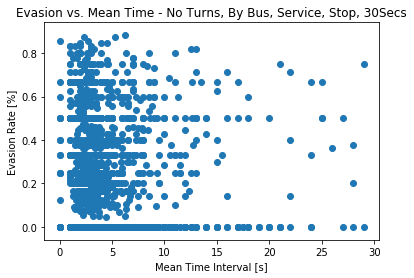

In [37]:
fig_1, ax_1 = plt.subplots()

ax_1.scatter(not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean'],not_null_mean_count_summary_no_turns['EVASION_RATE'])
ax_1.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 30Secs')
ax_1.set_xlabel('Mean Time Interval [s]')
ax_1.set_ylabel('Evasion Rate [%]')

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/9_30Secs_EvasionVsMeanTimeByBusByServiceByStop.pdf')

### Analyzing

In [56]:
print('Etapas_count MEAN: ' + str(not_null_mean_count_summary_no_turns['t_subida_count'].mean()))
print('Etapas_count MIN: ' + str(not_null_mean_count_summary_no_turns['t_subida_count'].min()))
print('Etapas_count MAX: ' + str(not_null_mean_count_summary_no_turns['t_subida_count'].max()))

print('Evasion_count MEAN: ' + str(not_null_mean_count_summary_no_turns['EVASION_COUNT'].mean()))
print('Evasion_count MIN: ' + str(not_null_mean_count_summary_no_turns['EVASION_COUNT'].min()))
print('Evasion_count MAX: ' + str(not_null_mean_count_summary_no_turns['EVASION_COUNT'].max()))

Etapas_count MEAN: 4.460925833748133
Etapas_count MIN: 2
Etapas_count MAX: 64
Evasion_count MEAN: 1.0418118466898956
Evasion_count MIN: 1.0
Evasion_count MAX: 2.0


* Checking for outliers: obs. with 'diferencia_tiempo_secs_mean'>=15

In [40]:
outliers_15_secs = not_null_mean_count_summary_no_turns[not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean']>=15]

In [57]:
len(outliers_15_secs.index)

56

In [61]:
print(outliers_15_secs['t_subida_count'].min())
print(outliers_15_secs['t_subida_count'].max())
print(outliers_15_secs['t_subida_count'].mean())

2
4
2.1607142857142856


* Looking for the first 5 rows in above sliced dataframe

In [41]:
outliers_15_secs.head()

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subida_min,t_subida_max,t_subida_count,diferencia_tiempo_secs_mean,group_b_flag,start_cut,end_cut,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,fecha_instalacion,SI_TORNIQUETE,SI_2017_TORNIQUETE,EVASION_RATE
216,ZN4100,418,36,L-9-7-25-PO,2017-03-14 10:34:17,2017-03-14 10:34:45,2,28.0,0,2017-03-14 10:33:47,2017-03-14 10:34:58,1.0,5.0,1.0,NaT,False,False,0.200000
431,BJFD69,508,50,L-32-19-10-OP,2017-03-15 10:32:48,2017-03-15 10:33:06,2,18.0,0,2017-03-15 10:32:41,2017-03-15 10:33:36,1.0,2.0,0.0,NaT,False,False,0.000000
1335,BJFR91,363,24,L-34-9-20-NS,2017-03-15 10:09:37,2017-03-15 10:09:57,2,20.0,0,2017-03-15 10:09:07,2017-03-15 10:10:27,1.0,2.0,0.0,NaT,False,False,0.000000
1345,BJFR93,363,35,L-33-51-20-SN,2017-03-15 13:06:48,2017-03-15 13:07:10,2,22.0,0,2017-03-15 13:06:18,2017-03-15 13:07:40,1.0,7.0,5.0,NaT,False,False,0.714286
1933,CJRT79,454,99,T-31-134-SN-25,2017-03-15 17:02:51,2017-03-15 17:03:10,2,19.0,0,2017-03-15 17:02:21,2017-03-15 17:03:40,1.0,3.0,0.0,NaT,False,False,0.000000


* Checking manually:
- row 216 > <font color='green'> passed </font>

In [42]:
date = '2017-03-14'

In [43]:
sitio_subida = 'ZN-4100'
servicio_subida = '418'
par_subida = 'L-9-7-25-PO'

In [44]:
etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
processed_sorted_df = etapas_builder.runProcessedProcess()

Not found in turnstile database: 1832615


In [45]:
processed_sorted_df.loc[(processed_sorted_df['sitio_subida']==sitio_subida)&(processed_sorted_df['servicio_subida'].str.contains(servicio_subida)&(processed_sorted_df['par_subida']==par_subida)),:]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
2182742,1125318,2166347283,1,BUS,2017-03-14 10:34:17,T418 00I,L-9-7-25-PO,ZN-4100,NaT,False,True,True,NaT,NaN,False,False
2182743,1360660,2514855566,1,BUS,2017-03-14 10:34:45,T418 00I,L-9-7-25-PO,ZN-4100,NaT,True,True,True,00:00:28,28.0,False,False


* row 431 > <font color='green'> passed </font>

In [46]:
date = '2017-03-15'

In [47]:
sitio_subida = 'BJFD-69'
servicio_subida = '508'
par_subida = 'L-32-19-10-OP'

In [48]:
etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
processed_sorted_df = etapas_builder.runProcessedProcess()

Not found in turnstile database: 1842842


In [49]:
processed_sorted_df.loc[(processed_sorted_df['sitio_subida']==sitio_subida)&(processed_sorted_df['servicio_subida'].str.contains(servicio_subida)&(processed_sorted_df['par_subida']==par_subida)),:]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
268384,2570567,4015981467,1,BUS,2017-03-15 10:32:48,T508 00R,L-32-19-10-OP,BJFD-69,NaT,False,True,True,NaT,NaN,False,False
268385,1767637,3118997620,1,BUS,2017-03-15 10:33:06,T508 00R,L-32-19-10-OP,BJFD-69,NaT,True,True,True,00:00:18,18.0,False,False


* row 1335 > <font color='green'> passed </font>

In [50]:
sitio_subida = 'BJFR-91'
servicio_subida = '363'
par_subida = 'L-34-9-20-NS'

In [51]:
processed_sorted_df.loc[(processed_sorted_df['sitio_subida']==sitio_subida)&(processed_sorted_df['servicio_subida'].str.contains(servicio_subida)&(processed_sorted_df['par_subida']==par_subida)),:]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
489619,821387,1359146886,1,BUS,2017-03-15 10:09:37,T363 00R,L-34-9-20-NS,BJFR-91,NaT,False,True,True,NaT,NaN,False,False
489620,1421635,2535677614,1,BUS,2017-03-15 10:09:57,T363 00R,L-34-9-20-NS,BJFR-91,NaT,True,True,True,00:00:20,20.0,False,False


* row 1345 > <font color='green'> passed </font>

In [52]:
sitio_subida = 'BJFR-93'
servicio_subida = '363'
par_subida = 'L-33-51-20-SN'

In [53]:
processed_sorted_df.loc[(processed_sorted_df['sitio_subida']==sitio_subida)&(processed_sorted_df['servicio_subida'].str.contains(servicio_subida)&(processed_sorted_df['par_subida']==par_subida)),:]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
490298,1479919,2686776462,1,BUS,2017-03-15 13:06:48,T363 00I,L-33-51-20-SN,BJFR-93,NaT,False,True,True,NaT,NaN,False,False
490299,1092762,2125105600,2,BUS,2017-03-15 13:07:10,T363 00I,L-33-51-20-SN,BJFR-93,NaT,True,True,True,00:00:22,22.0,False,False


* row 1933 > <font color='green'> passed </font>

In [54]:
sitio_subida = 'CJRT-79'
servicio_subida = '454'
par_subida = 'T-31-134-SN-25'

In [55]:
processed_sorted_df.loc[(processed_sorted_df['sitio_subida']==sitio_subida)&(processed_sorted_df['servicio_subida'].str.contains(servicio_subida)&(processed_sorted_df['par_subida']==par_subida)),:]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
1196009,2357959,3734809068,2,BUS,2017-03-15 13:27:40,T454 00I,T-31-134-SN-25,CJRT-79,NaT,False,True,True,NaT,NaN,False,False
1196070,749049,1096952068,2,BUS,2017-03-15 15:51:09,T454 00I,T-31-134-SN-25,CJRT-79,NaT,False,True,True,NaT,NaN,False,False
1196096,776789,1222075834,8,BUS,2017-03-15 17:02:51,T454 00I,T-31-134-SN-25,CJRT-79,NaT,False,True,True,NaT,NaN,False,False
1196097,2396900,3861960747,8,BUS,2017-03-15 17:03:10,T454 00I,T-31-134-SN-25,CJRT-79,NaT,True,True,True,00:00:19,19.0,False,False
1196155,1387270,2520151710,2,BUS,2017-03-15 18:54:06,T454 00I,T-31-134-SN-25,CJRT-79,NaT,False,True,True,NaT,NaN,False,False
1196156,2598132,4039063723,2,BUS,2017-03-15 18:54:06,T454 00I,T-31-134-SN-25,CJRT-79,NaT,True,True,True,00:00:00,0.0,False,False
1196157,2311080,3601671912,2,BUS,2017-03-15 18:54:08,T454 00I,T-31-134-SN-25,CJRT-79,NaT,True,True,True,00:00:02,2.0,False,False


* Box-plotting

In [265]:
import seaborn as sns

In [273]:
sns.set_style("whitegrid")
sns.set(font_scale = 0.9)

In [274]:
max_mean = int(not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean'].max())

In [275]:
step = 2
not_null_mean_count_summary_no_turns['boxplot_group']=''
observations = []
groups = []

for i in range(0,max_mean,step):
    not_null_mean_count_summary_no_turns.loc[(i<=not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean'])&(not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean']<i+step),'boxplot_group']=str(i) + '-' + str(i+step)
    observations.append(len(not_null_mean_count_summary_no_turns[(i<=not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean'])&(not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean']<i+step)].index))
    groups.append(str(i) + '-' + str(i+step))

C:\Users\leoca_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


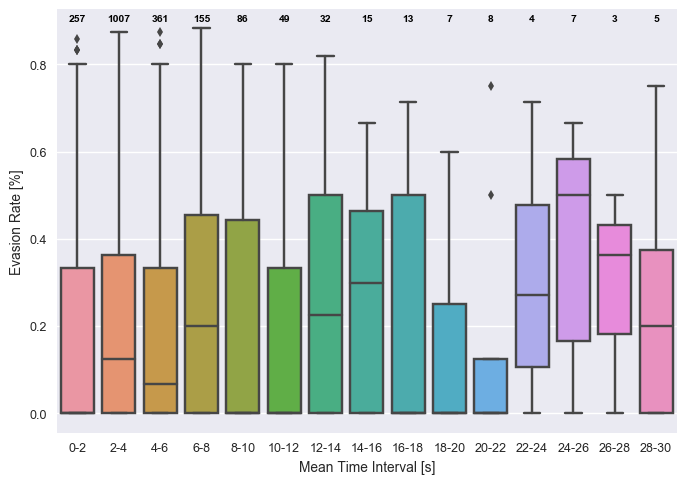

In [276]:
ax = sns.boxplot(x=not_null_mean_count_summary_no_turns['boxplot_group'], y=not_null_mean_count_summary_no_turns['EVASION_RATE'],order=groups)
ax.set_xlabel('Mean Time Interval [s]')
ax.set_ylabel('Evasion Rate [%]')


for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.9, observations[tick],
    horizontalalignment='center', size='x-small', color='k', weight='semibold')

fig = ax.get_figure()
#fig.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/10_30Secs_EvasionVsMeanTimeByBusByServiceByStop_boxPlot.pdf')

* Scatter plots by groups

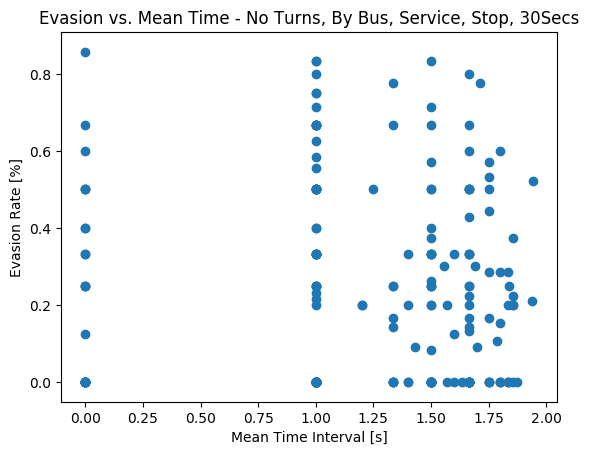

In [269]:
fig_2, ax_2 = plt.subplots()

ax_2.scatter(not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['boxplot_group']==groups[0],'diferencia_tiempo_secs_mean'],not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['boxplot_group']==groups[0],'EVASION_RATE'])
ax_2.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 30Secs')
ax_2.set_xlabel('Mean Time Interval [s]')
ax_2.set_ylabel('Evasion Rate [%]')

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/10_30Secs_EvasionVsMeanTimeByBusByServiceByStop_0-2.pdf')

* Checking why there is no obs. between 0.0 and 1.0

In [264]:
not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['diferencia_tiempo_secs_mean']==1,:]

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subida_min,t_subida_max,t_subida_count,diferencia_tiempo_secs_mean,group_b_flag,start_cut,end_cut,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,fecha_instalacion,SI_TORNIQUETE,SI_2017_TORNIQUETE,EVASION_RATE,boxplot_group
573,FLXG78,F05,22,L-22-4-25-OP,2017-03-09 10:35:30,2017-03-09 10:35:32,3,1.0,0,2017-03-09 10:35:00,2017-03-09 10:36:02,2.0,4.0,0.0,NaT,False,False,0.000000,0-2
1082,ZN6501,418,23,L-14-4-25-OP,2017-03-14 18:04:22,2017-03-14 18:04:24,3,1.0,0,2017-03-14 18:03:52,2017-03-14 18:04:54,1.0,2.0,1.0,NaT,False,False,0.500000,0-2
435,BJFD69,508,54,L-31-7-35-SN,2017-03-15 10:38:09,2017-03-15 10:38:10,2,1.0,0,2017-03-15 10:37:39,2017-03-15 10:38:40,1.0,8.0,2.0,NaT,False,False,0.250000,0-2
849,BJFF58,508,25,T-8-71-PO-45,2017-03-15 08:05:58,2017-03-15 08:05:59,2,1.0,0,2017-03-15 08:05:28,2017-03-15 08:06:29,1.0,4.0,0.0,NaT,False,False,0.000000,0-2
854,BJFF58,508,30,T-20-182-PO-15,2017-03-15 08:14:45,2017-03-15 08:14:48,4,1.0,0,2017-03-15 08:14:15,2017-03-15 08:15:18,1.0,6.0,0.0,NaT,False,False,0.000000,0-2
1589,BJFT26,363,284,L-33-51-10-SN,2017-03-15 10:38:22,2017-03-15 10:38:23,2,1.0,0,2017-03-15 10:37:52,2017-03-15 10:38:53,1.0,2.0,0.0,NaT,False,False,0.000000,0-2
1592,BJFT26,363,287,T-33-267-SN-35,2017-03-15 10:44:01,2017-03-15 10:44:02,2,1.0,0,2017-03-15 10:43:31,2017-03-15 10:44:32,1.0,2.0,0.0,NaT,False,False,0.000000,0-2
3285,YE9695,536,157,T-8-71-PO-15,2017-03-15 19:29:24,2017-03-15 19:29:26,3,1.0,0,2017-03-15 19:28:54,2017-03-15 19:29:56,1.0,4.0,1.0,NaT,False,False,0.250000,0-2
493,BJFB53,503,242,T-14-128-OP-20,2017-03-16 11:06:09,2017-03-16 11:06:11,3,1.0,0,2017-03-16 11:05:39,2017-03-16 11:06:41,1.0,3.0,0.0,NaT,False,False,0.000000,0-2
708,BJFD18,108,44,T-13-98-PO-45,2017-03-16 09:16:12,2017-03-16 09:16:13,2,1.0,0,2017-03-16 09:15:42,2017-03-16 09:16:43,1.0,1.0,0.0,NaT,False,False,0.000000,0-2


* Checking for row 854 > <font color='green'> passed </font>

In [258]:
date = '2017-03-15'
sitio_subida = 'BJFF-58'
servicio_subida = '508'
par_subida = 'T-20-182-PO-15'

In [259]:
etapas_builder = RunSilentlyDailyEtapasBuilderClass(date) #Critical.
processed_sorted_df = etapas_builder.runProcessedProcess()

Not found in turnstile database: 1842842


In [260]:
processed_sorted_df.loc[(processed_sorted_df['sitio_subida']==sitio_subida)&(processed_sorted_df['servicio_subida'].str.contains(servicio_subida)&(processed_sorted_df['par_subida']==par_subida)),:]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion,mismo_paradero,misma_patente,mismo_servicio,diferencia_tiempo,diferencia_tiempo_secs,si_torniquete,si_2017_torniquete
297721,837161,1403367774,1,BUS,2017-03-15 08:14:45,T508 01I,T-20-182-PO-15,BJFF-58,NaT,False,True,True,NaT,NaN,False,False
297722,1780119,3129300526,1,BUS,2017-03-15 08:14:45,T508 01I,T-20-182-PO-15,BJFF-58,NaT,True,True,True,00:00:00,0.0,False,False
297723,2076381,3486151102,1,BUS,2017-03-15 08:14:47,T508 01I,T-20-182-PO-15,BJFF-58,NaT,True,True,True,00:00:02,2.0,False,False
297724,693124,933544683,1,BUS,2017-03-15 08:14:48,T508 01I,T-20-182-PO-15,BJFF-58,NaT,True,True,True,00:00:01,1.0,False,False
297864,1854792,3169505406,1,BUS,2017-03-15 15:32:13,T508 00I,T-20-182-PO-15,BJFF-58,NaT,False,True,True,NaT,NaN,False,False
297865,2481416,3950432363,2,BUS,2017-03-15 15:32:13,T508 00I,T-20-182-PO-15,BJFF-58,NaT,True,True,True,00:00:00,0.0,False,False


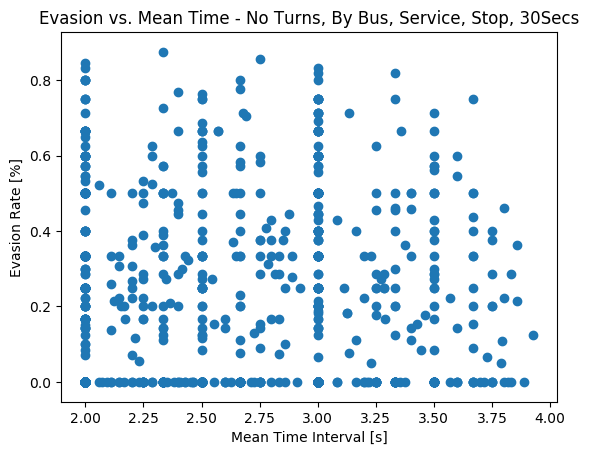

In [270]:
fig_2, ax_2 = plt.subplots()

ax_2.scatter(not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['boxplot_group']==groups[1],'diferencia_tiempo_secs_mean'],not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['boxplot_group']==groups[1],'EVASION_RATE'])
ax_2.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 30Secs')
ax_2.set_xlabel('Mean Time Interval [s]')
ax_2.set_ylabel('Evasion Rate [%]')
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/10_30Secs_EvasionVsMeanTimeByBusByServiceByStop_2-4.pdf')

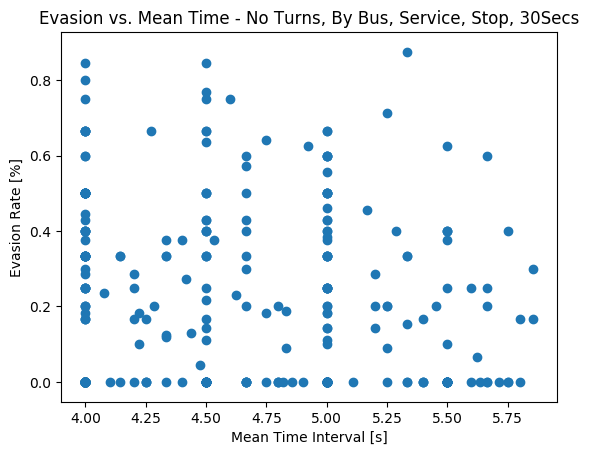

In [271]:
fig_2, ax_2 = plt.subplots()

ax_2.scatter(not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['boxplot_group']==groups[2],'diferencia_tiempo_secs_mean'],not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['boxplot_group']==groups[2],'EVASION_RATE'])
ax_2.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 30Secs')
ax_2.set_xlabel('Mean Time Interval [s]')
ax_2.set_ylabel('Evasion Rate [%]')
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/10_30Secs_EvasionVsMeanTimeByBusByServiceByStop_4-6.pdf')

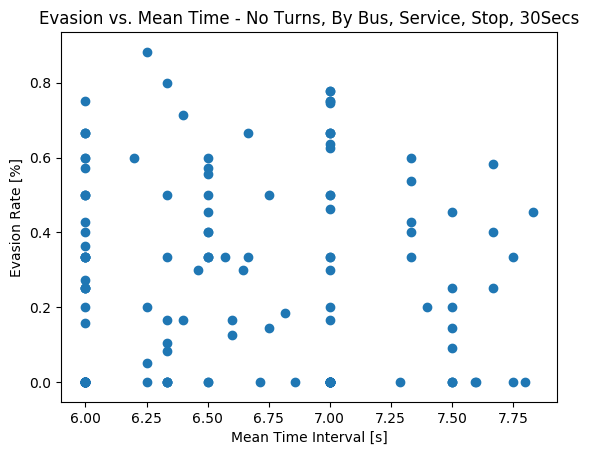

In [272]:
fig_2, ax_2 = plt.subplots()

ax_2.scatter(not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['boxplot_group']==groups[3],'diferencia_tiempo_secs_mean'],not_null_mean_count_summary_no_turns.loc[not_null_mean_count_summary_no_turns['boxplot_group']==groups[3],'EVASION_RATE'])
ax_2.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 30Secs')
ax_2.set_xlabel('Mean Time Interval [s]')
ax_2.set_ylabel('Evasion Rate [%]')
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/10_30Secs_EvasionVsMeanTimeByBusByServiceByStop_6-8.pdf')

### Plotting for different conditions

In [289]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [282]:
not_null_mean_count_summary_no_turns_10 = not_null_mean_count_summary_no_turns[not_null_mean_count_summary_no_turns['t_subida_count']>=10]

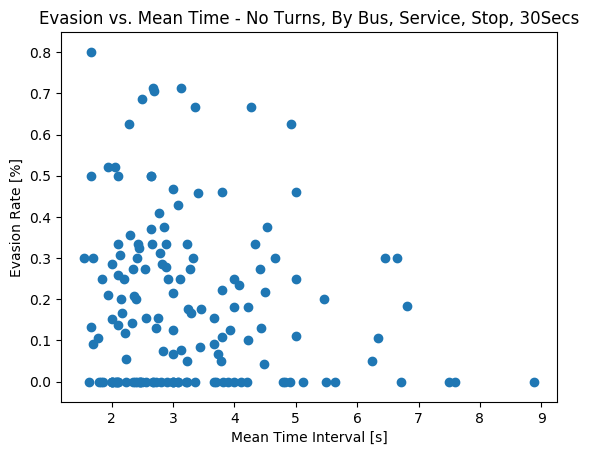

In [290]:
fig_1, ax_1 = plt.subplots()

ax_1.scatter(not_null_mean_count_summary_no_turns_10['diferencia_tiempo_secs_mean'],not_null_mean_count_summary_no_turns_10['EVASION_RATE'])
ax_1.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 30Secs')
ax_1.set_xlabel('Mean Time Interval [s]')
ax_1.set_ylabel('Evasion Rate [%]')

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/9_30Secs_EvasionVsMeanTimeByBusByServiceByStop.pdf')

In [284]:
not_null_mean_count_summary_no_turns_10.head()

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subida_min,t_subida_max,t_subida_count,diferencia_tiempo_secs_mean,group_b_flag,start_cut,end_cut,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,fecha_instalacion,SI_TORNIQUETE,SI_2017_TORNIQUETE,EVASION_RATE,boxplot_group
52,BKWK90,F05,53,L-34-12-10-PO,2017-03-09 09:01:47,2017-03-09 09:02:02,10,1.666667,0,2017-03-09 09:01:17,2017-03-09 09:02:32,1.0,4.0,2.0,NaT,False,False,0.500000,0-2
54,BKWK90,F05,55,L-34-59-10-PO,2017-03-09 09:04:02,2017-03-09 09:04:30,14,2.153846,0,2017-03-09 09:03:32,2017-03-09 09:05:00,2.0,5.0,1.0,NaT,False,False,0.200000,2-4
245,CJJH75,B07,137,L-6-32-20-NS,2017-03-09 18:45:35,2017-03-09 18:45:50,10,1.666667,0,2017-03-09 18:45:05,2017-03-09 18:46:20,1.0,5.0,4.0,2017-07-03,True,True,0.800000,0-2
1047,HRKS56,F05,501,T-34-270-SN-45,2017-03-09 12:53:51,2017-03-09 12:54:42,22,2.428571,0,2017-03-09 12:53:21,2017-03-09 12:55:12,2.0,6.0,2.0,2017-04-18,True,True,0.333333,2-4
427,BJFD69,508,47,L-32-19-40-OP,2017-03-15 10:29:03,2017-03-15 10:29:39,10,4.000000,0,2017-03-15 10:28:33,2017-03-15 10:30:09,2.0,22.0,4.0,NaT,False,False,0.181818,4-6


In [287]:
common_dates_evasion[(common_dates_evasion['FECHA']==pd.to_datetime('2017-03-09'))&(common_dates_evasion['SERVICIO']=='F05')&(common_dates_evasion['TIEMPO']>=pd.to_datetime('2017-03-09 12:53:21'))&(common_dates_evasion['TIEMPO']<=pd.to_datetime('2017-03-09 12:55:12'))]

,FECHA,HORA,HORA_INICIO,INGRESAN,LUGAR_INICIO,MINUTO,NO_VALIDAN,N_PUERTA,PATENTE,PUERTAS,TIEMPO,TP,SERVICIO_USUARIO,UN,SERVICIO
26439,2017-03-09,12,12:10:00,1,INTERMODAL LA CISTERNA,54,0,1,HRKS56,2,2017-03-09 12:54:00,P,F05,7.0,F05
91897,2017-03-09,12,12:10:00,5,INTERMODAL LA CISTERNA,55,2,1,HRKS56,2,2017-03-09 12:55:00,P,F05,7.0,F05
